![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Decoupling: Sorting bins method
</b>
</span>

---
**Notebook version**: `1` (19 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- Calculate daily correlation between two time series.


</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from diive.pkgs.analyses.decoupling import SortingBinsMethod
from diive.configs.exampledata import load_exampledata_parquet  # Example data
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.71.3


</br>

# **Load example data**

In [2]:
vpd_col = 'VPD_f'  # Vapor pressure deficit
nee_col = 'NEE_CUT_REF_f'  # Net ecosystem exchange of CO2
ta_col = 'Tair_f'  # Air temperature
swin_col = 'Rg_f'  # Radiation used to detect daytime data
# gpp_col = 'GPP_DT_CUT_REF'
# reco_col = 'Reco_DT_CUT_REF'

In [3]:
# Load 10-year dataset of half-hourly measurements
df = load_exampledata_parquet()

# Keep data between June and September
df = df.loc[(df.index.month >= 6) & (df.index.month <= 9)].copy()

# Keep daytime data (radiation > 50 W m-2) and data when air temperatures was > 5°C
daytime_locs = (df[swin_col] > 50) & (df[ta_col] > 5)  
df = df[daytime_locs].copy()

# Rename variables
rename_dict = {
    ta_col: 'air_temperature',
    vpd_col: 'vapor_pressure_deficit',
    nee_col: 'net_ecosystem_productivity'
}
df = df.rename(columns=rename_dict, inplace=False)

# Use new column names
ta_col = 'air_temperature'
vpd_col = 'vapor_pressure_deficit'
nee_col = 'net_ecosystem_productivity'

# Convert NEE to NEP
df[nee_col] = df[nee_col].multiply(-1)

# Make subset
df = df[[ta_col, vpd_col, nee_col]].copy()

df

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.055 seconds). Detected time resolution of <30 * Minutes> / 30T 


,air_temperature,vapor_pressure_deficit,net_ecosystem_productivity
TIMESTAMP_MIDDLE,,,
2013-06-01 11:15:00,5.500000,1.307000,4.241585
2013-06-01 11:45:00,5.233000,1.117000,-0.340710
2013-06-01 12:15:00,5.133000,1.148000,13.169810
2013-06-01 13:15:00,5.100000,0.855000,4.241585
2013-06-01 13:45:00,5.033000,0.895000,6.496005
...,...,...,...
2022-09-28 15:15:00,5.746667,1.039068,5.639862
2022-09-28 15:45:00,5.600000,0.939326,6.178556
2022-09-28 16:15:00,5.586667,1.243089,1.511982


</br>

# **Calculate bin medians**

In [4]:
sbm = SortingBinsMethod(df=df,
                        var1_col=ta_col,
                        var2_col=vpd_col,
                        var3_col=nee_col,
                        n_bins_var1=48,
                        n_subbins_var2=2,
                        convert_to_percentiles=False)
sbm.calcbins()

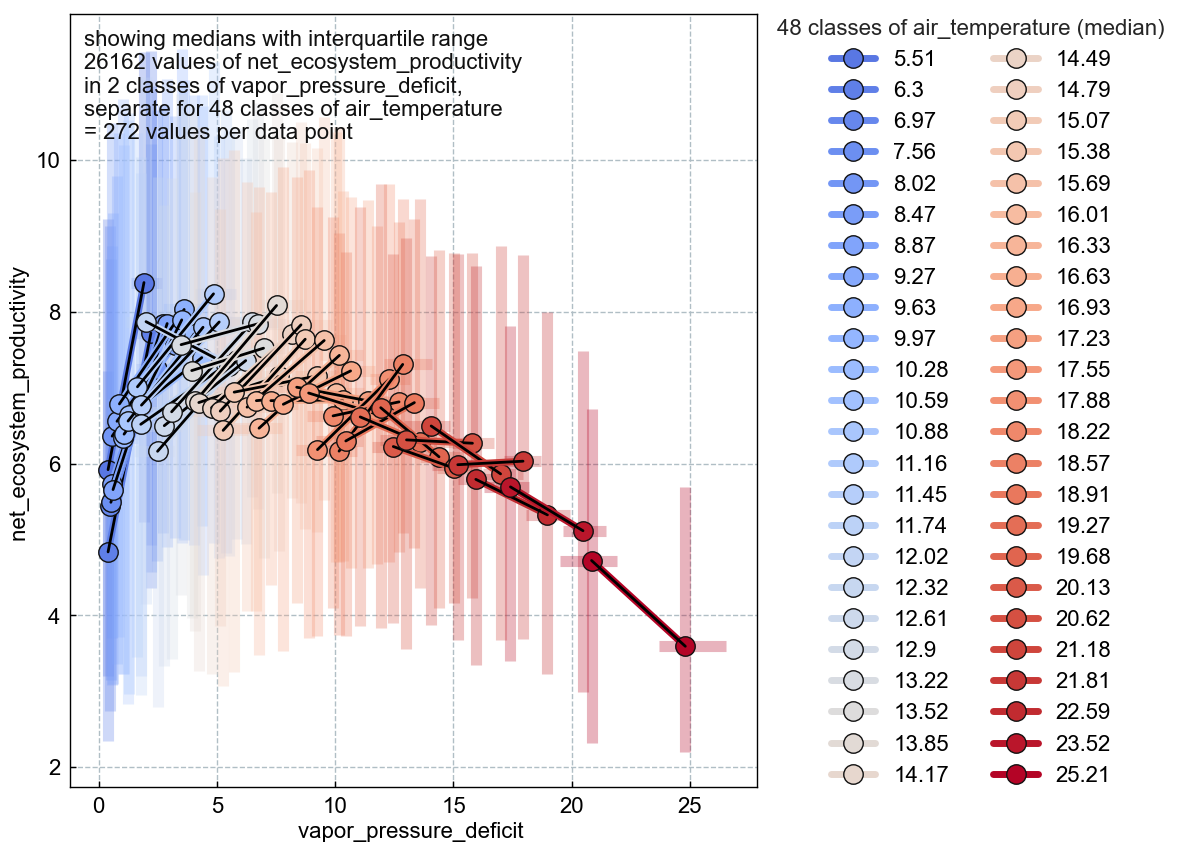

In [5]:
sbm.showplot_decoupling_sbm(marker='o', emphasize_lines=True)

Binning results (were also used to create the plot):

In [6]:
binmedians = sbm.get_binmeans()

In this example, the air temperature median is used as key in the results dictionary:

In [7]:
keys = []
for group_key, group_df in binmedians.items():
    keys.append(group_key)
print(keys, end=" ")

['5.51', '6.3', '6.97', '7.56', '8.02', '8.47', '8.87', '9.27', '9.63', '9.97', '10.28', '10.59', '10.88', '11.16', '11.45', '11.74', '12.02', '12.32', '12.61', '12.9', '13.22', '13.52', '13.85', '14.17', '14.49', '14.79', '15.07', '15.38', '15.69', '16.01', '16.33', '16.63', '16.93', '17.23', '17.55', '17.88', '18.22', '18.57', '18.91', '19.27', '19.68', '20.13', '20.62', '21.18', '21.81', '22.59', '23.52', '25.21'] 

To access the results for the warmest class:

In [8]:
binmedians['25.21']

,group_vapor_pressure_deficit,air_temperature,vapor_pressure_deficit,net_ecosystem_productivity,vapor_pressure_deficit_P25,net_ecosystem_productivity_P25,vapor_pressure_deficit_P75,net_ecosystem_productivity_P75,xerror_neg,xerror_pos,yerror_neg,yerror_pos
0,"(15.563, 22.806]",24.533,20.8355,4.723831,19.507874,2.319311,21.8900,6.721320,1.327626,1.0545,2.404520,1.997489
1,"(22.806, 32.118]",25.667,24.7975,3.594003,23.670250,2.207281,26.5275,5.694166,1.127250,1.7300,1.386722,2.100163


</br>

# **End of notebook**

In [9]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-03-19 17:06:54
